In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import os
import requests
from collections import defaultdict
from scipy import interpolate
import csv
import pandas as pd
from scipy import integrate
from scipy.optimize import curve_fit, minimize
from astropy.cosmology import FlatLambdaCDM

In [2]:
sampleA = pd.read_csv('sampleA_proj1.csv')[:5000]
sampleB = pd.read_csv('sampleB_proj1.csv')[:5000]

**Problem #1:** Compare the observed distribution of absolute magnitudes, sizes and surface brightnesses to the one corrected for selection effects using the Vmax technique (remember that Vmax depends on the apparent magnitude limit of
the survey and on the absolute magnitude, redshift and luminosity evolution and k-correction of the galaxy).

In [114]:
data = pd.DataFrame()
mask = ~np.isnan(sampleA['z']) & ~np.isnan(sampleA['M_r'])
data['z'] = sampleA['z'][mask]
data['M_r'] = sampleA['M_r'][mask]
data['k_r'] = sampleA['k_r'][mask]
data['dL_pc'] = sampleA['d_L'][mask] #pc
data['dL_kpc'] = data['dL_pc'] / 1000.0
data['Re_pc'] = sampleA['r_eff_r_arc'][mask]
data['Re_kpc'] = data['Re_pc'] / 206265
data['m_corr'] = 17.5 - data['k_r'] + data['z'] * 1.3
data['Mlim'] = data['m_corr'] - 5*np.log10(data['dL_kpc']) - 25
data['m_app'] = sampleA['modelmag_r'][mask]
data['size_r'] = sampleA['size_r'][mask]
data['sb_r'] = sampleA['sb_r'][mask]

In [26]:
#matching galaxies based on observed mag being less than Mlim:
matched_gals = data[data['M_r'] <= data['Mlim']]

In [121]:
sizeR = sampleA['r_eff_r'][mask]*data['dL_pc']

In [27]:
data

,z,M_r,k_r,dL_pc,dL_kpc,Re_pc,Re_kpc,m_corr,Mlim,m_app
0,0.089954,-21.310739,0.033516,4.115450e+08,411545.040196,1.450842,0.000007,17.583425,-35.488662,16.88488
1,0.097822,-21.863258,0.040893,4.499282e+08,449928.182445,2.131771,0.000010,17.586276,-35.679440,16.53957
2,0.175704,-22.096798,0.132537,8.492659e+08,849265.934952,1.417115,0.000007,17.595878,-37.049341,17.76671
3,0.122795,-21.369272,0.065931,5.741895e+08,574189.544327,1.740400,0.000008,17.593703,-36.201574,17.56859
4,0.186118,-22.668978,0.152860,9.052343e+08,905234.342088,1.808053,0.000009,17.589094,-37.194711,17.34772
...,...,...,...,...,...,...,...,...,...,...
4995,0.092157,-21.363661,0.035572,4.222532e+08,422253.188727,2.101839,0.000010,17.584232,-35.543633,16.95120
4996,0.152709,-21.929978,0.101571,7.277845e+08,727784.453678,1.170154,0.000006,17.596951,-36.713063,17.60707
4997,0.120813,-22.476265,0.063824,5.641940e+08,564194.027781,2.084541,0.000010,17.593233,-36.163909,16.46790
4998,0.090975,-20.779407,0.034462,4.165051e+08,416505.103552,1.019394,0.000005,17.583806,-35.514296,17.48553


In [8]:
print(np.max(data['z']))
print(np.min(data['z']))

0.24994
0.0300783


**Attempt 1: trying to find Mlim and Vlim by interpolating**

In [16]:
# Define your cosmological model
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [28]:
DL = cosmo.luminosity_distance(data['z']) #in Mpc. *1000 = kpc, *10**6 = pc

In [31]:
Vz_comoving = cosmo.comoving_volume(data['z'])

In [32]:
Vz_comoving

<Quantity [2.25016354e+08, 2.87753515e+08, 1.57552058e+09, ...,
           5.33178869e+08, 2.32596439e+08, 2.05500768e+08] Mpc3>

In [41]:
def M_lim(z, Q, k):
    mcorr = 17.5 - k + Q*z
    dL = cosmo.luminosity_distance(z).value
    return mcorr - 5*np.log10(dL*1000) - 25

In [83]:
z_arr = np.linspace(np.min(data['z']), np.max(data['z']), 4913)
Vz_arr = np.linspace(np.min(Vz_comoving), np.max(Vz_comoving), 4913)

M_lim_arr = M_lim(z_arr, 1.3, data['k_r'].values)
Vlim_Mlim_int = interpolate.interp1d(M_lim_arr, Vz_arr, bounds_error=False, fill_value='extrapolate')

Vlim_mpc = Vlim_Mlim_int(data['M_r'].values)

In [84]:
Vlim_mpc

array([-9.58101695e+08, -9.12764084e+08, -8.93600641e+08, ...,
       -8.62463046e+08, -1.00170082e+09, -9.81308694e+08])

In [85]:
Vlim_kpc = Vlim_mpc * (1000**3)

In [151]:
Vlim_kpc

array([-9.58101695e+17, -9.12764084e+17, -8.93600641e+17, ...,
       -8.62463046e+17, -1.00170082e+18, -9.81308694e+17])

In [110]:
weight = 1/Vlim_kpc
weight_norm = weight / np.sum(weight) / len(weight) 

In [111]:
weight_norm

array([3.91480002e-08, 4.10925079e-08, 4.19737449e-08, ...,
       4.34891275e-08, 3.74440798e-08, 3.82221880e-08])

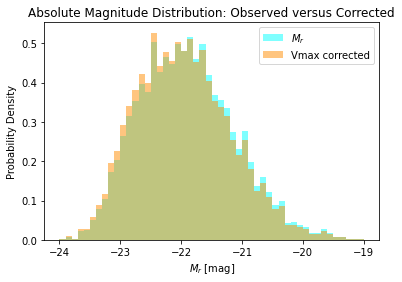

In [144]:
plt.hist(data["M_r"],bins=50,alpha=0.5,range = (-24, -19), label="$M_r$", color = 'cyan', density = True)
plt.hist(data["M_r"],weights = weight_norm, bins=50,alpha=0.5, range = (-24, -19), label="Vmax corrected", color = 'darkorange',density = True)
plt.title("Absolute Magnitude Distribution: Observed versus Corrected")
plt.xlabel("$M_r$ [mag]")
plt.ylabel('Probability Density')
plt.legend()
#plt.savefig("abs_mag_sampleA.png")

In [249]:
sizeR = sampleA['r_eff_r'][mask]*data['dL_pc']

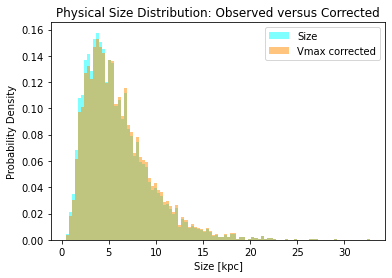

In [251]:
plt.hist(size_kpc,bins=100,alpha=0.5, label="Size", color = 'cyan', density = True)
plt.hist(size_kpc,weights = weight_norm, bins=100,alpha=0.5, label="Vmax corrected", color = 'darkorange',density = True)
plt.title("Physical Size Distribution: Observed versus Corrected")
plt.xlabel("Size [kpc]")
plt.ylabel('Probability Density')
plt.legend()

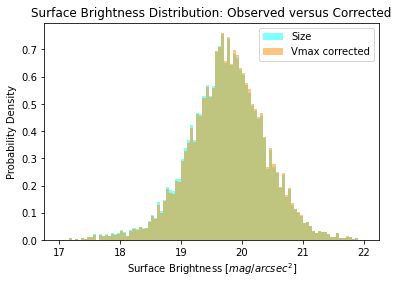

In [220]:
plt.hist(data['sb_r'],bins=100,alpha=0.5, range = (17,22), label="Size", color = 'cyan', density = True)
plt.hist(data['sb_r'],weights = weight_norm, bins=100,alpha=0.5, range = (17,22), label="Vmax corrected", color = 'darkorange',density = True)
plt.title("Surface Brightness Distribution: Observed versus Corrected")
plt.xlabel("Surface Brightness [$mag/arcsec^2$]")
plt.ylabel('Probability Density')
plt.legend()

**Attempt 2: using the values I already computed for sample A during project 1. Turned out much better**

In [171]:
x = (data['m_corr'] - data['Mlim']) / 5
dL_lim_pc = (10 ** x) * 10**(1/5) #pc
print(dL_lim_pc)

0       6.522549e+10
1       7.130881e+10
2       1.345996e+11
3       9.100291e+10
4       1.434700e+11
            ...     
4995    6.692262e+10
4996    1.153461e+11
4997    8.941873e+10
4998    6.601161e+10
4999    6.312367e+10
Length: 4913, dtype: float64


In [172]:
dL_lim_kpc = dL_lim_pc / 1000

In [174]:
dL_lim_kpc

0       6.522549e+07
1       7.130881e+07
2       1.345996e+08
3       9.100291e+07
4       1.434700e+08
            ...     
4995    6.692262e+07
4996    1.153461e+08
4997    8.941873e+07
4998    6.601161e+07
4999    6.312367e+07
Length: 4913, dtype: float64

In [175]:
Vlim_2 = (4/3)*np.pi*(dL_lim_kpc**3)

In [176]:
Vlim_2

0       1.162360e+24
1       1.518862e+24
2       1.021456e+25
3       3.156854e+24
4       1.237006e+25
            ...     
4995    1.255473e+24
4996    6.428312e+24
4997    2.994843e+24
4998    1.204896e+24
4999    1.053574e+24
Length: 4913, dtype: float64

In [177]:
weight2 = 1/Vlim_2
weight_norm2 = weight2 / np.sum(weight2) / len(weight2) 

In [180]:
np.max(weight_norm)

5.1534656192328744e-08

In [193]:
Vlim_2arr = np.linspace(np.min(Vlim_2), np.max(Vlim_2), 4913)

In [194]:
def fit_Q(Q):
    Mlim_fit = M_lim(z_arr, Q, data['k_r'].values)
    Vz_M_interpfit = interpolate.interp1d(Mlim_fit, Vlim_2arr, bounds_error=False, fill_value='extrapolate')
    Vlim_fit = Vz_M_interpfit(data['M_r'].values)

    mask_fit = np.isnan(Vlim_fit)
    return np.abs(np.sum(Vlim_2arr[~mask_fit] / Vlim_fit[~mask_fit]) - (len(data['M_r'].values[~mask_fit]) / 2))

In [199]:
# Minimize the function
result = minimize(fit_Q, 1.3)

# Optimal value of Q
optimal_Q = result.x[0]
print("Optimal Q:", optimal_Q)

Optimal Q: 1.3


**PLOTTING**

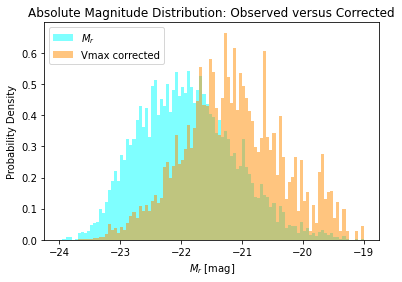

In [254]:
plt.hist(data["M_r"],bins=100,alpha=0.5,range = (-24, -19), label="$M_r$", color = 'cyan', density = True)
plt.hist(data["M_r"],weights = weight_norm2, bins=100,alpha=0.5, range = (-24, -19), label="Vmax corrected", color = 'darkorange',density = True)
plt.title("Absolute Magnitude Distribution: Observed versus Corrected")
plt.xlabel("$M_r$ [mag]")
plt.ylabel('Probability Density')
plt.legend()
plt.savefig("abs_mag_dist_vmax.png")

In [223]:
sizeR = sampleA['r_eff_r'][mask]*data['dL_pc']
print(sizeR)

0       2894.756312
1       4650.056929
2       5834.763360
3       4844.833265
4       7934.995773
           ...     
4995    4302.756416
4996    4128.764209
4997    5701.817337
4998    2058.432699
4999    2001.226319
Length: 4913, dtype: float64


In [235]:
size_kpc = sizeR/1000

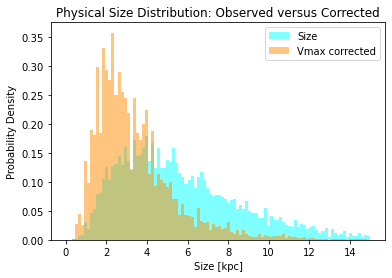

In [255]:
plt.hist(size_kpc,bins=100,alpha=0.5,range = (0,15), label="Size", color = 'cyan', density = True)
plt.hist(size_kpc,weights = weight_norm2, bins=100,alpha=0.5, range = (0,15), label="Vmax corrected", color = 'darkorange', density = True)
plt.title("Physical Size Distribution: Observed versus Corrected")
plt.xlabel("Size [kpc]")
plt.ylabel('Probability Density')
plt.legend()
plt.savefig("size_dist_vmax.png")

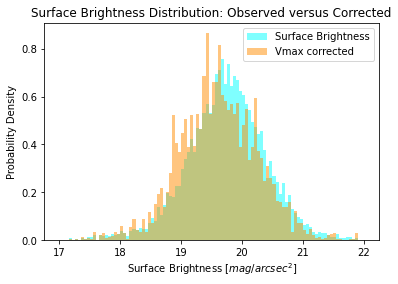

In [256]:
plt.hist(data['sb_r'],bins=100,alpha=0.5, range = (17,22), label="Surface Brightness", color = 'cyan', density = True)
plt.hist(data['sb_r'],weights = weight_norm2, bins=100,alpha=0.5, range = (17,22), label="Vmax corrected", color = 'darkorange',density = True)
plt.title("Surface Brightness Distribution: Observed versus Corrected")
plt.xlabel("Surface Brightness [$mag/arcsec^2$]")
plt.ylabel('Probability Density')
plt.legend()
plt.savefig("surf_brightness_dist_vmax.png")

**PART 2**

In [75]:
gal3 = pd.read_csv('gal3_linear.csv',sep="\s+",header=0)
gal10 = pd.read_csv('gal10_linear.csv', sep="\s+",header=0)
gal14 = pd.read_csv('gal14_linear.csv', sep="\s+",header=0)

In [84]:
gal3['mu[mag/arcsec^2]']

0     17.3960
1     17.8876
2     18.4037
3     18.8007
4     19.1298
       ...   
70    24.4903
71    24.5221
72    24.4612
73    24.5965
74    24.5046
Name: mu[mag/arcsec^2], Length: 75, dtype: float64

In [76]:
gal3

,#Rad[arcsec],mu[mag/arcsec^2]
0,0.104712,17.3960
1,0.207469,17.8876
2,0.338161,18.4037
3,0.469179,18.8007
4,0.601372,19.1298
...,...,...
70,9.389190,24.4903
71,9.522120,24.5221
72,9.655260,24.4612
73,9.788590,24.5965


In [ ]:
"""

def dev_fit(R_e, mu_e):
    mu = mu_e + 8.327*[(R/R_e)**0.25-1]
    return mu

def exp_fit(R_e, mu_e):
    mu = mu_e + (2.5*1.67/np.log(10))*((R/R_e) - 1)
    return mu

def dev_exp_fit(R_e, mu_dev ,mu_exp):
    return dev_fit(R_e, mu_dev) + exp_fit(R_e, mu_exp)
"""

In [78]:
def sersic_fit(R, R_e, mu_e, n):
    b = 1.999*n - 0.327
    mu = mu_e + (2.5*b/np.log(10))*((R/R_e)**(1/n) - 1)
    return mu

def dev_fit(R, R_e, mu_e):
    mu = mu_e + 8.327*((R/R_e)**0.25-1)
    return mu

def exp_fit(R, R_e, mu_e):
    mu = mu_e + (2.5*1.67/np.log(10))*((R/R_e) - 1)
    return mu

def dev_exp_fit(R, R_e, mu_dev ,mu_exp):
    return dev_fit(R, R_e, mu_dev) + exp_fit(R, R_e, mu_exp)

In [79]:
gal3x = gal3['#Rad[arcsec]'].values
gal3y = gal3['mu[mag/arcsec^2]'].values

gal10x = gal10['#Rad[arcsec]'].values
gal10y = gal10['mu[mag/arcsec^2]'].values

gal14x = gal14['#Rad[arcsec]'].values
gal14y = gal14['mu[mag/arcsec^2]'].values

In [80]:
params3_ser, _ = curve_fit(sersic_fit, gal3x, gal3y) #Re, mu_e, n
params3_dev, _ = curve_fit(dev_fit, gal3x, gal3y) #Re, mu_e
params3_exp, _ = curve_fit(exp_fit, gal3x, gal3y) #Re, mu_e
params3_devexp, _ = curve_fit(dev_exp_fit, gal3x, gal3y) #Re, mudev, muexp

In [81]:
params10_ser, _ = curve_fit(sersic_fit, gal3x, gal3y) #Re, mu_e, n
params10_dev, _ = curve_fit(dev_fit, gal3x, gal3y) #Re, mu_e
params10_exp, _ = curve_fit(exp_fit, gal3x, gal3y) #Re, mu_e
params10_devexp, _ = curve_fit(dev_exp_fit, gal3x, gal3y) #Re, mudev, muexp

In [82]:
params14_ser, _ = curve_fit(sersic_fit, gal3x, gal3y) #Re, mu_e, n
params14_dev, _ = curve_fit(dev_fit, gal3x, gal3y) #Re, mu_e
params14_exp, _ = curve_fit(exp_fit, gal3x, gal3y) #Re, mu_e
params14_devexp, _ = curve_fit(dev_exp_fit, gal3x, gal3y) #Re, mudev, muexp

In [83]:
gal3y_serfit = sersic_fit(gal3x, *params3_ser)
res3ser = gal3y - gal3y_serfit

gal3y_devfit = dev_fit(gal3x, *params3_dev)
res3dev = gal3y - gal3y_devfit

gal3y_devexpfit = dev_exp_fit(gal3x, *params3_devexp)
res3devexp = gal3y - gal3y_devexpfit

# Calculate the sum of squared residuals
sum_res_ser = np.sum(res3ser**2)
sum_res_dev = np.sum(res3dev**2)
sum_res_devexp = np.sum(res3devexp**2)

# Find the fit with the minimal sum of squared residuals
best_fit = min(sum_res_ser, sum_res_dev, sum_res_devexp)

if best_fit == sum_res_ser:
    print("Sersic Fit is the best.")
elif best_fit == sum_res_dev:
    print("DeVaucouleur Fit is the best.")
else:
    print("DeVaucouleur + Exponential Fit is the best.")

Sersic Fit is the best.


**PLOTTING $\mu$ versus R with Sersic, de Vaucouleur and de Vaucouleur + exp profiles**

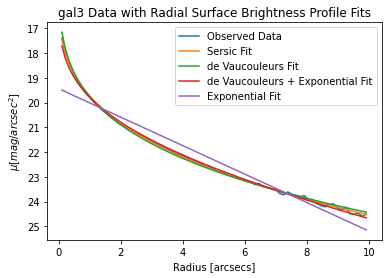

In [85]:
#gal3:
plt.plot(gal3x, gal3y, label='Observed Data')
plt.plot(gal3x, sersic_fit(gal3x, *params3_ser), label='Sersic Fit')
plt.plot(gal3x, dev_fit(gal3x, *params3_dev), label='de Vaucouleurs Fit')
plt.plot(gal3x, dev_exp_fit(gal3x, *params3_devexp), label='de Vaucouleurs + Exponential Fit')
plt.plot(gal3x, exp_fit(gal3x, *params3_exp), label='Exponential Fit')
plt.xlabel('Radius [arcsecs]')
plt.ylabel('$\mu [mag/arcsec^2]$')
plt.gca().invert_yaxis()
plt.title('gal3 Data with Radial Surface Brightness Profile Fits')
plt.legend()
plt.savefig("gal3_R_vs_mu.png")
plt.show()

In [54]:
#gal3
gal3y_serfit = sersic_fit(gal3x, *params3_ser)
res3ser = gal3y - gal3y_serfit

gal3y_devfit = dev_fit(gal3x, *params3_dev)
res3dev = gal3y - gal3y_devfit

gal3y_devexpfit = dev_exp_fit(gal3x, *params3_devexp)
res3devexp = gal3y - gal3y_devexpfit

# Calculate the sum of squared residuals
sum_res_ser = np.sum(res3ser**2)
sum_res_dev = np.sum(res3dev**2)
sum_res_devexp = np.sum(res3devexp**2)

# Find the fit with the minimal sum of squared residuals
best_fit = min(sum_res_ser, sum_res_dev, sum_res_devexp)

if best_fit == sum_res_ser:
    print("Sersic Fit is the best.")
elif best_fit == sum_res_dev:
    print("DeVaucouleur Fit is the best.")
else:
    print("DeVaucouleur + Exponential Fit is the best.")

Sersic Fit is the best.


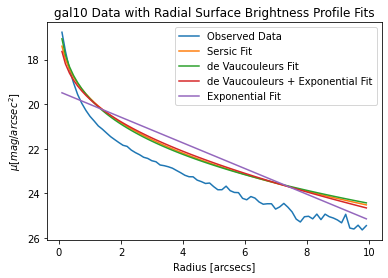

In [86]:
#gal10:
plt.plot(gal10x, gal10y, label='Observed Data')
plt.plot(gal10x, sersic_fit(gal10x, *params10_ser), label='Sersic Fit')
plt.plot(gal10x, dev_fit(gal10x, *params10_dev), label='de Vaucouleurs Fit')
plt.plot(gal10x, dev_exp_fit(gal10x, *params10_devexp), label='de Vaucouleurs + Exponential Fit')
plt.plot(gal10x, exp_fit(gal10x, *params10_exp), label='Exponential Fit')
plt.xlabel('Radius [arcsecs]')
plt.ylabel('$\mu [mag/arcsec^2]$')
plt.gca().invert_yaxis()
plt.title('gal10 Data with Radial Surface Brightness Profile Fits')
plt.legend()
plt.savefig("gal10_R_vs_mu.png")
plt.show()

In [48]:
gal10y_serfit = sersic_fit(gal10x, *params10_ser)
res10ser = gal10y - gal10y_serfit

gal10y_devfit = dev_fit(gal10x, *params10_dev)
res10dev = gal10y - gal10y_devfit

gal10y_devexpfit = dev_exp_fit(gal10x, *params10_devexp)
res10devexp = gal10y - gal10y_devexpfit

# Calculate the sum of squared residuals
sum_res_ser = np.sum(res10ser**2)
sum_res_dev = np.sum(res10dev**2)
sum_res_devexp = np.sum(res10devexp**2)

# Find the fit with the minimal sum of squared residuals
best_fit = min(sum_res_ser, sum_res_dev, sum_res_devexp)

if best_fit == sum_res_ser:
    print("Sersic Fit is the best.")
elif best_fit == sum_res_dev:
    print("DeVaucouleur Fit is the best.")
else:
    print("DeVaucouleur + Exponential Fit is the best.")

DeVaucouleur Fit is the best.


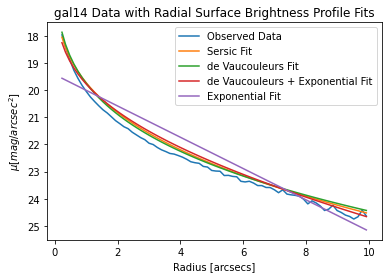

In [87]:
#gal14:
plt.plot(gal14x, gal14y, label='Observed Data')
plt.plot(gal14x, sersic_fit(gal14x, *params14_ser), label='Sersic Fit')
plt.plot(gal14x, dev_fit(gal14x, *params14_dev), label='de Vaucouleurs Fit')
plt.plot(gal14x, dev_exp_fit(gal14x, *params14_devexp), label='de Vaucouleurs + Exponential Fit')
plt.plot(gal14x, exp_fit(gal14x, *params14_exp), label='Exponential Fit')
plt.xlabel('Radius [arcsecs]')
plt.ylabel('$\mu [mag/arcsec^2]$')
plt.gca().invert_yaxis()
plt.title('gal14 Data with Radial Surface Brightness Profile Fits')
plt.legend()
plt.savefig("gal14_R_vs_mu.png")
plt.show()

In [50]:
gal14y_serfit = sersic_fit(gal14x, *params14_ser)
res14ser = gal14y - gal14y_serfit

gal14y_devfit = dev_fit(gal14x, *params14_dev)
res14dev = gal14y - gal14y_devfit

gal14y_devexpfit = dev_exp_fit(gal14x, *params14_devexp)
res14devexp = gal14y - gal14y_devexpfit

# Calculate the sum of squared residuals
sum_res_ser = np.sum(res14ser**2)
sum_res_dev = np.sum(res14dev**2)
sum_res_devexp = np.sum(res14devexp**2)

# Find the fit with the minimal sum of squared residuals
best_fit = min(sum_res_ser, sum_res_dev, sum_res_devexp)

if best_fit == sum_res_ser:
    print("Sersic Fit is the best.")
elif best_fit == sum_res_dev:
    print("DeVaucouleur Fit is the best.")
else:
    print("DeVaucouleur + Exponential Fit is the best.")

DeVaucouleur Fit is the best.


*****************************************************************************************************

**PART 3**

Select galaxies with similar luminosities, i.e. in small absolute magnitude bins
(e.g. bin size=0.5mag), and plot ci versus redshift computing the median of ci in
small redshift bins (delta z ~ 0.02).

In [2]:
import seaborn as sns

In [3]:
sampleA = pd.read_csv('sampleA_proj1.csv')[:5000]
sampleB = pd.read_csv('sampleB_proj1.csv')[:5000]

In [4]:
#Sample A:
#binning by magnitude and z:
sampleA['mag_bin'] = np.floor(sampleA['M_r'] / 0.5) * 0.5
sampleA['z_bin'] = np.floor(sampleA['z'] / 0.02) * 0.02

mag_bins_a = np.sort(np.unique(sampleA['mag_bin'][~np.isnan(sampleA['M_r'])]))[::-1]
z_bins_a = np.sort(np.unique(sampleA['z_bin'][~np.isnan(sampleA['z'])]))

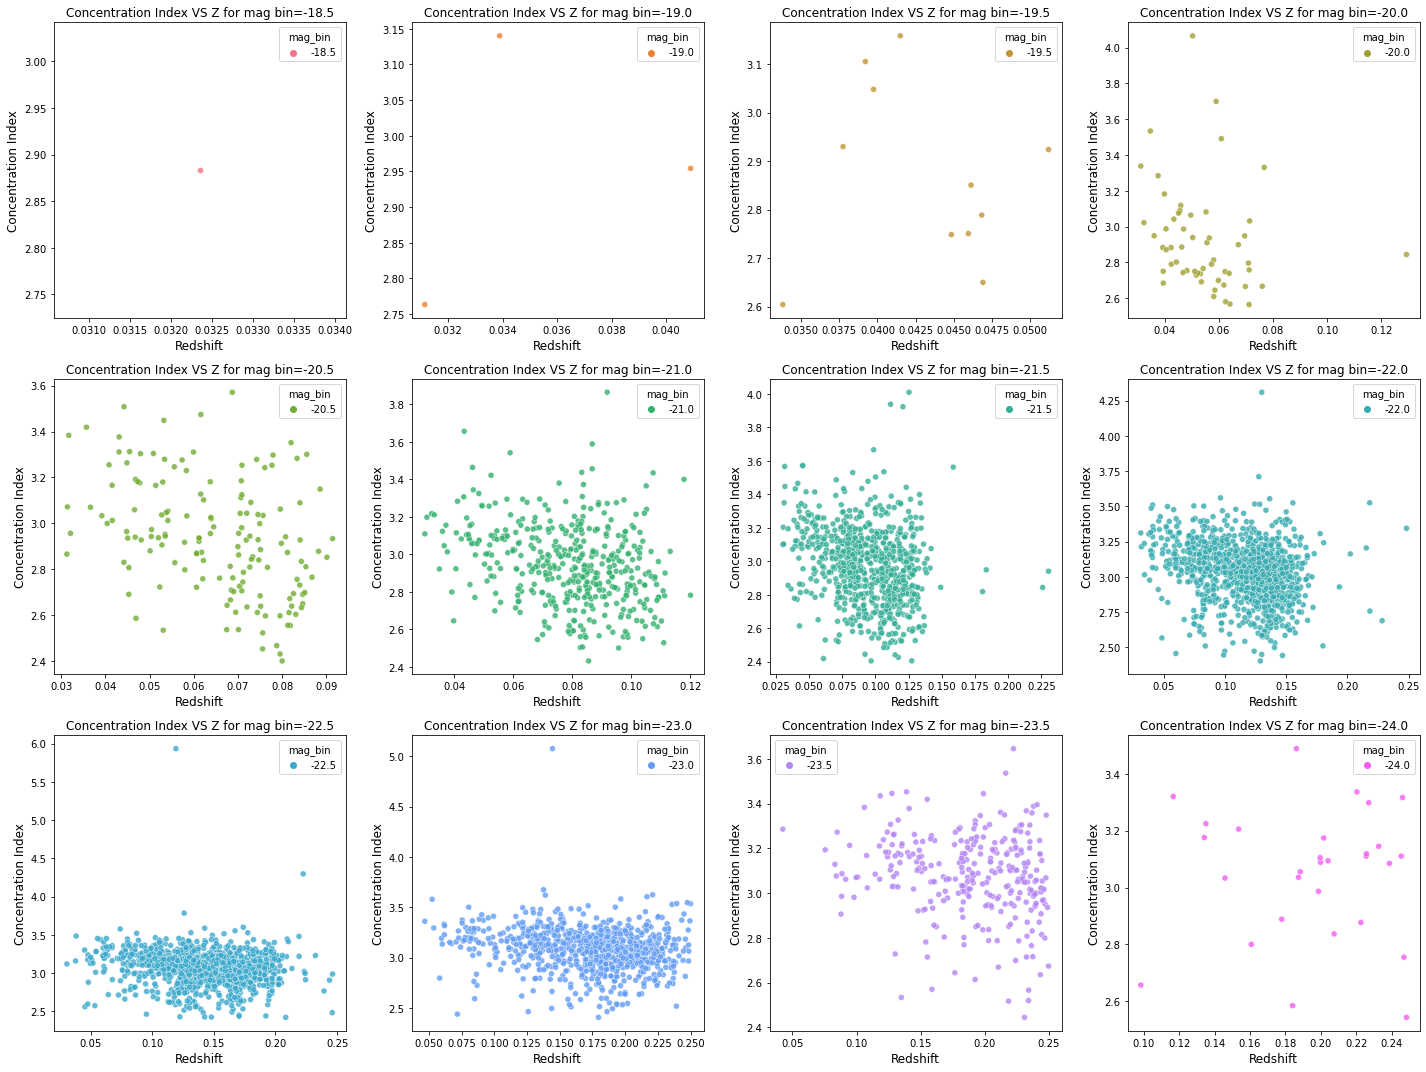

In [6]:
# Create a color palette with the number of unique magnitude bins
colors_a = sns.color_palette("husl", n_colors=len(mag_bins_a))

# Create subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

# Loop over each magnitude bin
for mag_bin, color, ax in zip(mag_bins_a, colors_a, axs.flatten()):
    # Select Galaxies in Specific Magnitude Bin
    group = sampleA[sampleA['mag_bin'] == mag_bin]

    # Check if the group is empty
    if not group.empty:
        # Plot 'ci' versus 'redshift'
        sns.scatterplot(data=group, x="z", y="concentration_index", hue="mag_bin", alpha=0.8, palette=[color], ax=ax)
        ax.set_xlabel("Redshift", fontsize=12)
        ax.set_ylabel("Concentration Index", fontsize=12)
        ax.set_title(f'Concentration Index VS Z for mag bin={mag_bin}', fontsize=12)

plt.savefig("ci_vs_z_subplotsA.png")
# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
# Create a color palette with the number of unique magnitude bins
colors_a = sns.color_palette("husl", n_colors=len(mag_bins_a))
ci_a = []
z_a = []

# Loop over each magnitude bin
for mag_bin, color, ax in zip(mag_bins_a, colors_a, axs.flatten()):
    ci_loop = []
    z_loop = []
    # Select Galaxies in Specific Magnitude Bin
    group = sampleA[sampleA['mag_bin'] == mag_bin]
    
    # Loop over each redshift bin within the magnitude bin
    for z_bin in z_bins_a:
        #z.append(z_bin)
        #Select Galaxies in Specific Redshift Bin within Magnitude Bin
        z_data = group[group['z_bin'] == z_bin]

        # Compute the Median of 'ci' in Redshift Bin
        ci_med = z_data['concentration_index'].median()
        ci_loop.append(ci_med)
        z_loop.append(z_bin)

    ci_a.append(ci_loop)
    z_a.append(z_loop)

In [10]:
ci_df_A = pd.DataFrame()

ci_df_A['z_bin'] = z_bins_a

# Iterate over the lists in ci
for idx, ci_list in enumerate(ci_a):
    ci_df_A['ci_med' + str(idx)] = ci_list

In [17]:
ci_df_A 

,z_bin,ci_med0,ci_med1,ci_med2,ci_med3,ci_med4,ci_med5,ci_med6,ci_med7,ci_med8,ci_med9,ci_med10,ci_med11
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.02,2.883271,2.951708,2.988806,3.021654,3.070387,3.109257,3.121929,3.224796,3.159482,NaN,NaN,NaN
2,0.04,NaN,2.954375,2.788652,2.870259,3.034906,3.082164,3.142173,3.180960,3.175964,3.294347,3.285492,NaN
3,0.06,NaN,NaN,NaN,2.748424,2.872890,2.934041,3.025881,3.121623,3.208696,3.197030,3.193004,NaN
4,0.08,NaN,NaN,NaN,NaN,2.765915,2.901394,2.980812,3.092578,3.153713,3.200821,3.072999,2.657331
5,0.10,NaN,NaN,NaN,NaN,NaN,2.861192,2.910142,3.060416,3.131577,3.128825,3.125946,3.319921
6,0.12,NaN,NaN,NaN,2.843575,NaN,2.781783,2.937910,3.009130,3.076662,3.162478,3.179218,3.200042
7,0.14,NaN,NaN,NaN,NaN,NaN,NaN,3.017709,2.981786,3.058200,3.133178,3.122961,3.119391
8,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.984149,2.998544,3.081916,3.050974,2.844677
9,0.18,NaN,NaN,NaN,NaN,NaN,NaN,2.883767,3.084891,3.060803,3.059160,3.093975,3.055104


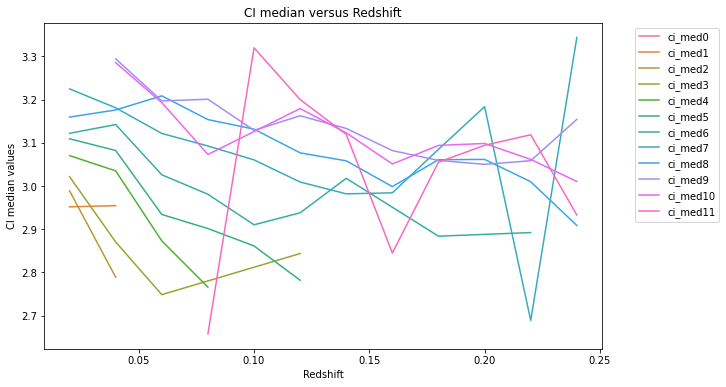

In [45]:
# Replace df with your DataFrame
plt.figure(figsize=(10, 6))

# Melt the DataFrame
melted_A = pd.melt(ci_df_A, id_vars='z_bin', var_name='ci_medX', value_name='value')

# Plot using Seaborn
sns.lineplot(x='z_bin', y='value', hue='ci_medX', data=melted_A)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Redshift')
plt.ylabel('CI median values')
plt.title('CI median versus Redshift')
plt.savefig("ci_vs_z_lineplotA.png")
plt.show()

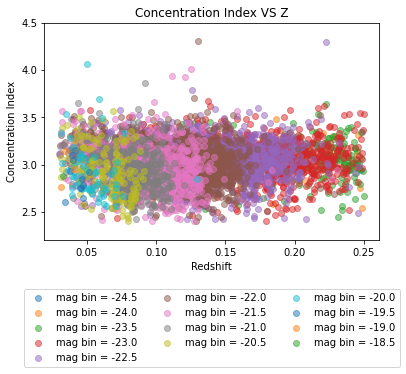

In [69]:
grouped_data = sampleA.groupby('mag_bin')
for label, group in grouped_data:
    plt.scatter(group['z'], group['concentration_index'], label=f'mag bin = {label}',alpha = 0.5)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.ylim(2.3,5.5)
plt.xlabel("Redshift")
plt.ylabel("Concentration Index")
plt.title(f'Concentration Index VS Z')
plt.ylim(2.2,4.5)

plt.savefig("ci_vs_z_single_scatterA.png")

# Show the plot
plt.show()

In [7]:
#Sample B:
#binning by magnitude and z:
sampleB['mag_bin'] = np.floor(sampleB['M_r'] / 0.5) * 0.5
sampleB['z_bin'] = np.floor(sampleB['z'] / 0.02) * 0.02

mag_bins_b = np.sort(np.unique(sampleB['mag_bin'][~np.isnan(sampleB['M_r'])]))[::-1]
z_bins_b = np.sort(np.unique(sampleB['z_bin'][~np.isnan(sampleB['z'])]))

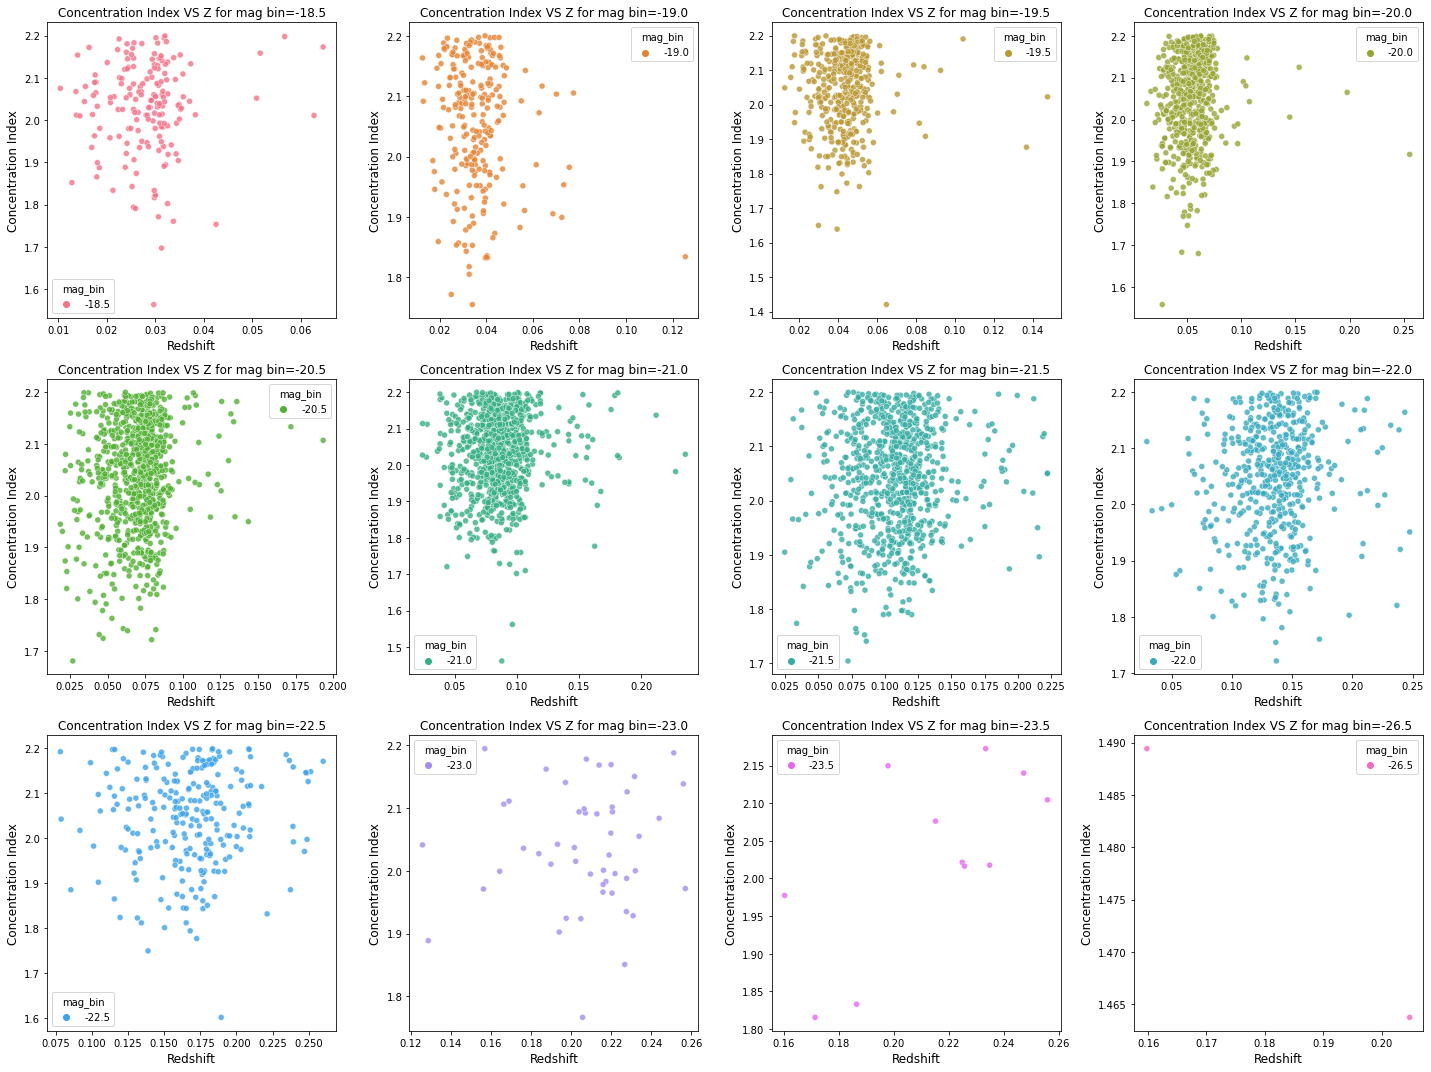

In [8]:
mag_bins_b = mag_bins_b[11:23]
# Create a color palette with the number of unique magnitude bins
colors_b = sns.color_palette("husl", n_colors=len(mag_bins_b))

# Create subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

# Loop over each magnitude bin
for mag_bin, color, ax in zip(mag_bins_b, colors_b, axs.flatten()):
    # Select Galaxies in Specific Magnitude Bin
    group = sampleB[sampleB['mag_bin'] == mag_bin]

    # Check if the group is empty
    if not group.empty:
        # Plot 'ci' versus 'redshift'
        sns.scatterplot(data=group, x="z", y="concentration_index", hue="mag_bin", alpha=0.8, palette=[color], ax=ax)
        ax.set_xlabel("Redshift", fontsize=12)
        ax.set_ylabel("Concentration Index", fontsize=12)
        ax.set_title(f'Concentration Index VS Z for mag bin={mag_bin}', fontsize=12)

plt.savefig("ci_vs_z_subplotsB.png")
# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
# Create a color palette with the number of unique magnitude bins
colors_b = sns.color_palette("husl", n_colors=len(mag_bins_b))
ci_b = []
z_b = []

# Loop over each magnitude bin
for mag_bin, color, ax in zip(mag_bins_b, colors_b, axs.flatten()):
    ci_loop = []
    z_loop = []
    # Select Galaxies in Specific Magnitude Bin
    group = sampleB[sampleB['mag_bin'] == mag_bin]
    
    # Loop over each redshift bin within the magnitude bin
    for z_bin in z_bins_b:
        #z.append(z_bin)
        #Select Galaxies in Specific Redshift Bin within Magnitude Bin
        z_data = group[group['z_bin'] == z_bin]

        # Compute the Median of 'ci' in Redshift Bin
        ci_med = z_data['concentration_index'].median()
        ci_loop.append(ci_med)
        z_loop.append(z_bin)

    ci_b.append(ci_loop)
    z_b.append(z_loop)

In [12]:
ci_df_b = pd.DataFrame()

ci_df_b['z_bin'] = z_bins_b

# Iterate over the lists in ci
for idx, ci_list in enumerate(ci_b):
    ci_df_b['ci_med' + str(idx)] = ci_list

In [13]:
ci_df_b

,z_bin,ci_med0,ci_med1,ci_med2,ci_med3,ci_med4,ci_med5,ci_med6,ci_med7,ci_med8,ci_med9,ci_med10,ci_med11
0,0.00,2.038475,2.091597,2.094403,2.038386,1.937874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.02,2.043473,2.069364,2.045500,2.030985,2.033663,2.058174,1.966139,2.049958,NaN,NaN,NaN,NaN
2,0.04,2.105355,2.096993,2.053794,2.054487,2.040356,1.992707,2.072202,1.936933,NaN,NaN,NaN,NaN
3,0.06,2.092084,1.986381,2.085317,2.076586,2.056114,2.044126,2.038615,2.063111,2.117629,NaN,NaN,NaN
4,0.08,NaN,NaN,2.022703,1.984142,2.051535,2.046202,2.058391,1.996396,2.017434,NaN,NaN,NaN
5,0.10,NaN,NaN,2.190494,2.085499,2.102821,2.058554,2.051637,2.052871,2.084680,NaN,NaN,NaN
6,0.12,NaN,1.833934,1.876678,NaN,2.115122,2.055283,2.061822,2.059588,2.024445,1.965028,NaN,NaN
7,0.14,NaN,NaN,2.022538,2.065250,1.949747,2.079580,2.038814,2.065400,2.069027,2.082810,NaN,1.489429
8,0.16,NaN,NaN,NaN,NaN,2.133154,1.950233,2.030994,2.081836,2.042439,2.071095,1.896502,NaN
9,0.18,NaN,NaN,NaN,2.064944,2.106827,2.025662,2.083533,2.058175,2.066402,2.027278,1.991316,NaN


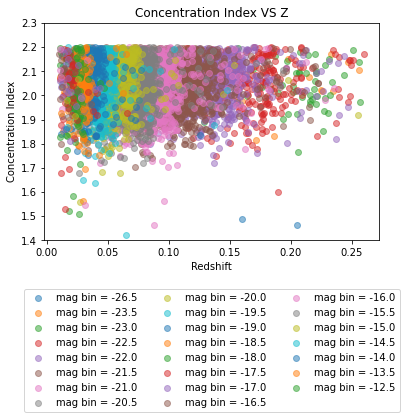

In [64]:
grouped_data = sampleB.groupby('mag_bin')
for label, group in grouped_data:
    plt.scatter(group['z'], group['concentration_index'], label=f'mag bin = {label}',alpha = 0.5)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
#plt.ylim(2.3,5.5)
plt.xlabel("Redshift")
plt.ylabel("Concentration Index")
plt.title(f'Concentration Index VS Z')
plt.ylim(1.4,2.3)

plt.savefig("ci_vs_z_single_scatterB.png")

# Show the plot
plt.show()

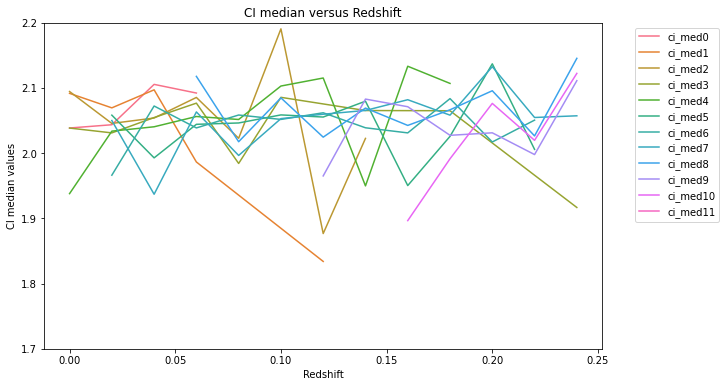

In [46]:
# Replace df with your DataFrame
plt.figure(figsize=(10, 6))

# Melt the DataFrame
melted_B = pd.melt(ci_df_b, id_vars='z_bin', var_name='ci_medX', value_name='value')

# Plot using Seaborn
sns.lineplot(x='z_bin', y='value', hue='ci_medX', data=melted_B)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(1.7, 2.2)
plt.xlabel('Redshift')
plt.ylabel('CI median values')
plt.title('CI median versus Redshift')
plt.savefig("ci_vs_z_lineplotB.png")
plt.show()

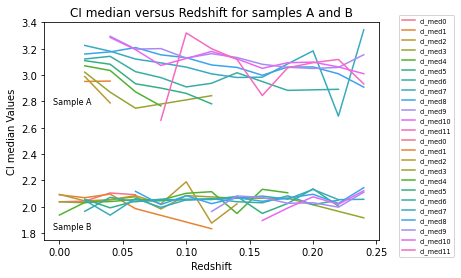

In [49]:
#plotting both sample A and B:

# Melt the DataFrames and reset index
melted_A = pd.melt(ci_df_A, id_vars='z_bin', var_name='ci_medX', value_name='value').reset_index()
melted_B = pd.melt(ci_df_b, id_vars='z_bin', var_name='ci_medX', value_name='value').reset_index()

# Rename the 'z_bin' column to avoid conflicts
#melted_A = melted_A.rename(columns={'z_bin': 'z_bin_A'})
#melted_B = melted_B.rename(columns={'z_bin': 'z_bin_B'})

# Add a prefix to ci_medX column based on the source DataFrame
melted_A = melted_A.add_prefix('A_')
melted_B = melted_B.add_prefix('B_')

# Combine the melted DataFrames
combined_df = pd.concat([melted_A, melted_B])

# Plot the combined data
sns.lineplot(x='A_z_bin', y='A_value', hue='A_ci_medX', data=combined_df)
sns.lineplot(x='B_z_bin', y='B_value', hue='B_ci_medX', data=combined_df)

plt.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', fontsize=6.5)

# Add text to the plot
plt.text(0.01, 2.80, 'Sample A', fontsize=8, ha='center', va='center')#, transform=plt.gca().transAxes)
plt.text(0.01, 1.85, 'Sample B', fontsize=8, ha='center', va='center')#, transform=plt.gca().transAxes)

plt.xlabel('Redshift')
plt.ylabel('CI median Values')
plt.ylim(1.75,3.4)
plt.title('CI median versus Redshift for samples A and B')

plt.savefig("ci_vs_z_lineplotAandB.png")
plt.show()

*******************************************************************************************************

**PART 4**

For sample A (ETG's), use the physical deV radius (i.e. in kpc). You have already computed and the absolute magnitude in the r-band (where you corrected for evolution, i.e. evolcorr_absmag_r=obs_absmag_r + 0.9 x redshift). <br>
<br>
Compute the median of devRkpc_r in small evolcorr_absmag bins. <br>
<br>
Now do the same using devRkpc_g instead of devRkpc_r but still use the evolcorr_absmag in the r-band (it would help to understand the problem if you could also get the i-band values of deV radius, i.e. devrad_i). <br>
<br>
Plot the difference of the median values of devRkpc_g - devRkpc_r vs the
evolcorr_absmag bin (and devRkpc_r - devRkpc_i if you have the i-band
values).

In [70]:
sampleA['devRkpc_r'] = sampleA['devrad_r'] / 206265
sampleA['devRkpc_g'] = sampleA['devrad_g'] / 206265
sampleA['ev_corr_absMr'] = sampleA['M_r'] + 0.9 * sampleA['z']

sampleA['evcorr_bin'] = np.floor(sampleA['ev_corr_absMr'] / 0.5) * 0.5

evcorr_bins = np.sort(np.unique(sampleA['evcorr_bin'][~np.isnan(sampleA['ev_corr_absMr'])]))[::-1]

In [71]:
med_dev_r = []
med_dev_g = []
for bin in evcorr_bins:
    group = sampleA[sampleA['evcorr_bin'] == bin]
    med_devRkpc_r = group['devRkpc_r'].median()
    med_dev_r.append(med_devRkpc_r)
    
    med_devRkpc_g = group['devRkpc_g'].median()
    med_dev_g.append(med_devRkpc_g)

In [72]:
med_r = np.array(med_dev_r)
med_g = np.array(med_dev_g)
diff = med_g - med_r

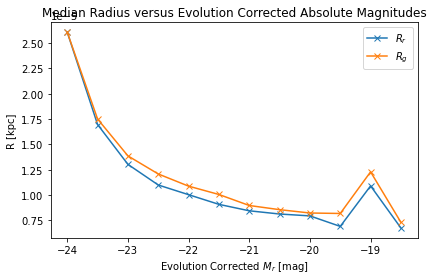

In [94]:
plt.plot(evcorr_bins, med_r, label = '$R_r$', marker = 'x')
plt.plot(evcorr_bins, med_g, label = '$R_g$', marker = 'x')
plt.xlabel('Evolution Corrected $M_r$ [mag]')
plt.ylabel('R [kpc]')
plt.title('Median Radius versus Evolution Corrected Absolute Magnitudes')
plt.legend()
plt.tight_layout()
plt.savefig('Rg_Rr_vs_evolcorr_Mr.png')
plt.show()

In [92]:
med_r

array([6.74936126e-06, 1.09054469e-05, 6.90861271e-06, 7.94530822e-06,
       8.13060868e-06, 8.44810802e-06, 9.08449567e-06, 1.00385087e-05,
       1.09949531e-05, 1.30309844e-05, 1.69615931e-05, 2.60768841e-05])

In [73]:
diff_format = np.log10(np.abs(diff))
print(diff_format)

[-6.25078824 -5.85754276 -5.89426425 -6.54472335 -6.36800275 -6.28105205
 -6.01138616 -6.07479577 -5.96341624 -6.07695721 -6.26397231 -8.17109841]


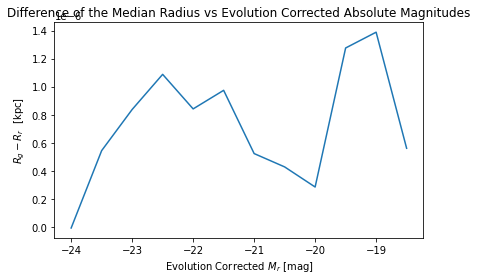

In [95]:
plt.plot(evcorr_bins, diff)
plt.xlabel('Evolution Corrected $M_r$ [mag]')
plt.ylabel('$R_g - R_r$  [kpc]')
plt.title('Difference of the Median Radius vs Evolution Corrected Absolute Magnitudes')
plt.tight_layout()
plt.show()

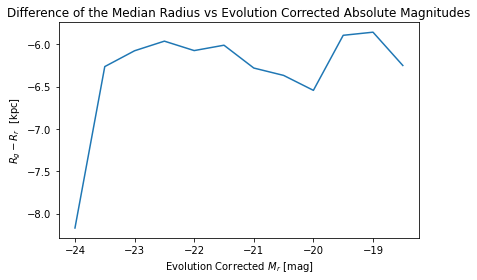

In [96]:
plt.plot(evcorr_bins, diff_format)
plt.xlabel('Evolution Corrected $M_r$ [mag]')
plt.ylabel('$R_g - R_r$  [kpc]')
plt.title('Difference of the Median Radius vs Evolution Corrected Absolute Magnitudes')
plt.tight_layout()
plt.savefig('med_R_vs_evolcorr_Mr.png')
plt.show()